In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt

In [107]:
def showImage(image):
    %matplotlib inline  

    plt.imshow(image, interpolation='nearest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.colorbar()
    plt.show()
    
def showImage_cat(image,numCat):
    %matplotlib inline  

    plt.imshow(image, interpolation='nearest', cmap=plt.cm.get_cmap('Greens', numCat))
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.colorbar(ticks=np.arange(numCat))
    plt.show()
    
def showBWImage(image):
    %matplotlib inline  

    plt.imshow(image, interpolation='nearest',cmap='gray')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.colorbar()
    plt.show()
    
def showImage_clim(image, minValue, maxValue):
    %matplotlib inline  

    plt.imshow(image, interpolation='nearest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.colorbar()
    plt.clim(minValue,maxValue)
    plt.show()
    
def showImage_autoSize(image):
    %matplotlib inline 

    plt.imshow(image,  aspect='auto', interpolation='none')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.colorbar()
    plt.show()

def showImage_autoSize_clim(image, minValue, maxValue):
    %matplotlib inline 

    plt.imshow(image,  aspect='auto', interpolation='none')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.colorbar()
    plt.clim(minValue,maxValue)
    plt.show()

In [4]:
XDIM = 250
YDIM = 250
ZDIM = 50

numVar = 2

In [14]:
raw_data = np.zeros((numVar,ZDIM,YDIM,XDIM))

temp_data = np.fromfile("/home/hazarika/visData/isabel_MV_t20/Pf20.binLE.raw_corrected_2_subsampled", dtype=np.float32)
raw_data[0] = temp_data.reshape((ZDIM,YDIM,XDIM))

temp_data = np.fromfile("/home/hazarika/visData/isabel_MV_t20/Velocityf20.binLE.raw_corrected_2_subsampled", dtype=np.float32)
raw_data[1] = temp_data.reshape((ZDIM,YDIM,XDIM))


In [18]:
#currently working with 2d data in python for visualization
#store the extracted slices in separate array
raw_slice = np.zeros((numVar, YDIM,XDIM))
raw_slice[0] = raw_data[0][10]
raw_slice[1] = raw_data[1][10]

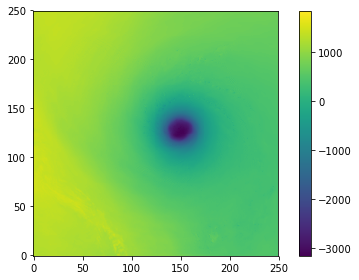

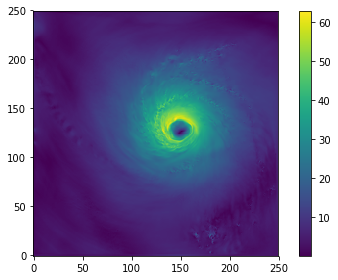

In [19]:
showImage(raw_slice[0])
showImage(raw_slice[1])

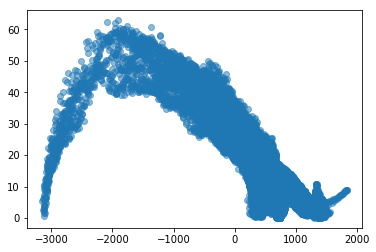

In [23]:
#scatter plot of the MV
plt.scatter(raw_slice[0].flatten(), raw_slice[1].flatten(), alpha=0.5)
plt.show()

In [62]:
stepSize = 10
downSampled_Array = np.zeros((numVar,(YDIM/stepSize)*(XDIM/stepSize),stepSize*stepSize))

idx = 0
for i in range(0,YDIM,stepSize):
    for j in range(0,XDIM,stepSize):
        c = 0
        for ii in range(i,i+stepSize):
            for jj in range(j,j+stepSize):
                downSampled_Array[0][idx][c] = raw_slice[0][ii][jj]
                downSampled_Array[1][idx][c] = raw_slice[1][ii][jj]
                c += 1 
        idx += 1

In [63]:
from scipy import stats
from scipy.stats import norm
import sys
import math

In [72]:
ds_mean = np.zeros((numVar,(YDIM/stepSize)*(XDIM/stepSize)))
ds_correl = np.zeros((1,(YDIM/stepSize)*(XDIM/stepSize)))
for i in range(0,(YDIM/stepSize)*(XDIM/stepSize)):
    ds_mean[0][i] = np.mean(downSampled_Array[0][i])
    ds_mean[1][i] = np.mean(downSampled_Array[1][i])
    ds_correl[0][i] = stats.pearsonr(downSampled_Array[0][i],downSampled_Array[1][i])[0]
        
        

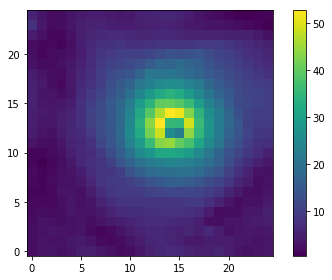

In [73]:
showImage(ds_mean[1].reshape(25,25))

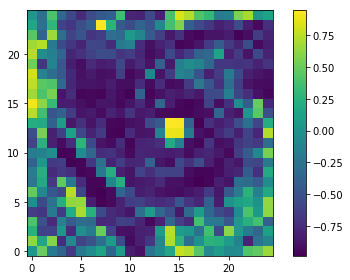

In [75]:
showImage(ds_correl[0].reshape(25,25))

In [181]:
#normality test
pvalue = np.zeros((numVar,(YDIM/stepSize)*(XDIM/stepSize)))

for i in range(0,(YDIM/stepSize)*(XDIM/stepSize)):
    s,p = stats.normaltest(downSampled_Array[0][i])
    pvalue[0][i] = p
    s,p = stats.normaltest(downSampled_Array[1][i])
    pvalue[1][i] = p
    


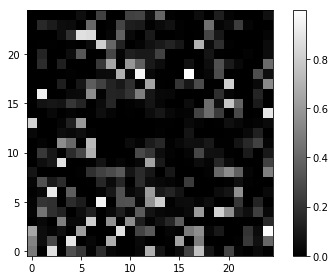

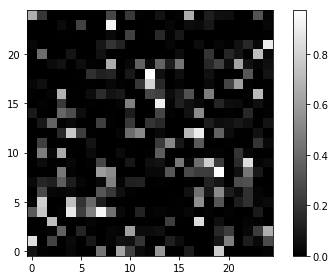

In [184]:
showBWImage(pvalue[0].reshape(25,25))
showBWImage(pvalue[1].reshape(25,25))

In [67]:
from sklearn.cluster import KMeans
import numpy as np


In [128]:
numCluster = 2
kmeans = KMeans(n_clusters=numCluster, random_state=0).fit(np.transpose(ds_correl))


In [129]:
correl_cluster = np.zeros((YDIM/stepSize)*(XDIM/stepSize),dtype=np.int32)

for i in range(0,(YDIM/stepSize)*(XDIM/stepSize)):
    correl_cluster[i] = kmeans.labels_[i]

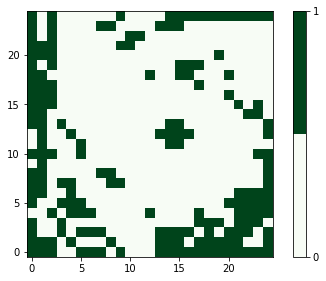

In [130]:
showImage_cat(correl_cluster.reshape(25,25),numCluster)

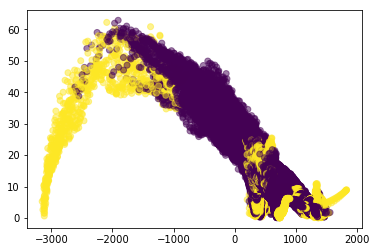

In [131]:
#scatter plot of the MV with categories
raw_categories = np.zeros((YDIM,XDIM))
for i in range(0,YDIM):
    for j in range(0,XDIM):
        newX = int(j/10)
        newY = int(i/10)
        raw_categories[i][j] = correl_cluster[newY*(XDIM/stepSize) + newX]

fig, ax = plt.subplots()
        
plt.scatter(raw_slice[0].flatten(), raw_slice[1].flatten(), c=raw_categories.flatten(), label=raw_categories.flatten(), alpha=0.5)
#plt.legend()
plt.show()

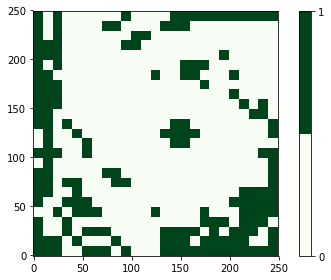

In [132]:
showImage_cat(raw_categories,numCluster)

In [127]:
#store the distributions per block
#first Gaussian then histogram
ds_Gaussian = np.zeros((numVar,(YDIM/stepSize)*(XDIM/stepSize),2))

for i in range(0,(YDIM/stepSize)*(XDIM/stepSize)):
    ds_Gaussian[0][i][0] =  np.mean(downSampled_Array[0][i])
    ds_Gaussian[0][i][1] =  np.std(downSampled_Array[0][i])
    ds_Gaussian[1][i][0] =  np.mean(downSampled_Array[1][i])
    ds_Gaussian[1][i][1] =  np.std(downSampled_Array[1][i])



In [158]:
ds_Hist_cdf = np.zeros((numVar,(YDIM/stepSize)*(XDIM/stepSize),32))
ds_Hist_binEdges = np.zeros((numVar,(YDIM/stepSize)*(XDIM/stepSize),33))

for i in range(0,(YDIM/stepSize)*(XDIM/stepSize)):
    hist0, bin_edges0 = np.histogram(downSampled_Array[0][i], density=True, bins=32)
    cdf0 = np.cumsum(hist0*np.diff(bin_edges0))
    ds_Hist_cdf[0][i] = cdf0
    ds_Hist_binEdges[0][i] = bin_edges0
    
    hist1, bin_edges1 = np.histogram(downSampled_Array[1][i], density=True, bins=32)
    cdf1 = np.cumsum(hist1*np.diff(bin_edges1))
    ds_Hist_cdf[1][i] = cdf1
    ds_Hist_binEdges[1][i] = bin_edges1
    

In [167]:
ds_Hist_cdf[1][100]
ds_Hist_binEdges[0][200]

array([ 1375.06079102,  1378.40974426,  1381.75869751,  1385.10765076,
        1388.456604  ,  1391.80555725,  1395.1545105 ,  1398.50346375,
        1401.85241699,  1405.20137024,  1408.55032349,  1411.89927673,
        1415.24822998,  1418.59718323,  1421.94613647,  1425.29508972,
        1428.64404297,  1431.99299622,  1435.34194946,  1438.69090271,
        1442.03985596,  1445.3888092 ,  1448.73776245,  1452.0867157 ,
        1455.43566895,  1458.78462219,  1462.13357544,  1465.48252869,
        1468.83148193,  1472.18043518,  1475.52938843,  1478.87834167,
        1482.22729492])

In [138]:
#store the correlation information for the clusters
print kmeans.cluster_centers_[0][0]
print kmeans.cluster_centers_[1][0]


-0.709916372818
0.215903437441


In [153]:
#reconstruction using mote-carlo sampling
recon_data0 = np.zeros(((numVar, YDIM,XDIM)))

for y in range(0,YDIM/stepSize):
    for x in range(0,XDIM/stepSize):
        correl_matrix = np.zeros((numVar,numVar))
        block_correl = kmeans.cluster_centers_[correl_cluster[y*(XDIM/stepSize) + x]]
        correl_matrix[0][0] = 1.0
        correl_matrix[0][1] = block_correl
        correl_matrix[1][0] = 1.0
        correl_matrix[1][1] = block_correl
        
        mean_vector = np.zeros((numVar)) #standard normals have 0 mean
        
        sampledata = np.random.multivariate_normal(mean_vector, correl_matrix, 5*10*10)
        uData = norm.cdf(sampledata)
                
        #for each grid take average of 5 samples
        MVsamples = np.zeros((5*10*10,numVar))
        for k in range(0,5*10*10):
            MVsamples[k][0] = stats.norm.ppf(q=uData[k,0],loc=ds_Gaussian[0][y*(XDIM/stepSize) + x][0],scale=ds_Gaussian[0][y*(XDIM/stepSize) + x][1])
            MVsamples[k][1] = stats.norm.ppf(q=uData[k,1],loc=ds_Gaussian[1][y*(XDIM/stepSize) + x][0],scale=ds_Gaussian[1][y*(XDIM/stepSize) + x][1])
        
        MVsamples1 = np.zeros((10*10,numVar))
        for k in range(0,10*10):
            t_sum0 = 0.0
            t_sum1 = 0.0
            for l in range(0,5):
                t_sum0 += MVsamples[k*5+l][0]
                t_sum1 += MVsamples[k*5+l][1]
            MVsamples1[k][0] = t_sum0/5.0
            MVsamples1[k][1] = t_sum1/5.0
        idx = 0
        for yy in range(0,10):
            for xx in range(0,10):
                recon_data0[0][y*10+yy][x*10+xx] = MVsamples1[idx][0]
                recon_data0[1][y*10+yy][x*10+xx] = MVsamples1[idx][1]
                idx += 1
        print "[" + str(y) + "][" + str(x) + "]"  
                   

[0][0]
[0][1]
[0][2]
[0][3]


/home/hazarika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


[0][4]
[0][5]
[0][6]
[0][7]
[0][8]
[0][9]
[0][10]
[0][11]
[0][12]
[0][13]
[0][14]
[0][15]
[0][16]
[0][17]
[0][18]
[0][19]
[0][20]
[0][21]
[0][22]
[0][23]
[0][24]
[1][0]
[1][1]
[1][2]
[1][3]
[1][4]
[1][5]
[1][6]
[1][7]
[1][8]
[1][9]
[1][10]
[1][11]
[1][12]
[1][13]
[1][14]
[1][15]
[1][16]
[1][17]
[1][18]
[1][19]
[1][20]
[1][21]
[1][22]
[1][23]
[1][24]
[2][0]
[2][1]
[2][2]
[2][3]
[2][4]
[2][5]
[2][6]
[2][7]
[2][8]
[2][9]
[2][10]
[2][11]
[2][12]
[2][13]
[2][14]
[2][15]
[2][16]
[2][17]
[2][18]
[2][19]
[2][20]
[2][21]
[2][22]
[2][23]
[2][24]
[3][0]
[3][1]
[3][2]
[3][3]
[3][4]
[3][5]
[3][6]
[3][7]
[3][8]
[3][9]
[3][10]
[3][11]
[3][12]
[3][13]
[3][14]
[3][15]
[3][16]
[3][17]
[3][18]
[3][19]
[3][20]
[3][21]
[3][22]
[3][23]
[3][24]
[4][0]
[4][1]
[4][2]
[4][3]
[4][4]
[4][5]
[4][6]
[4][7]
[4][8]
[4][9]
[4][10]
[4][11]
[4][12]
[4][13]
[4][14]
[4][15]
[4][16]
[4][17]
[4][18]
[4][19]
[4][20]
[4][21]
[4][22]
[4][23]
[4][24]
[5][0]
[5][1]
[5][2]
[5][3]
[5][4]
[5][5]
[5][6]
[5][7]
[5][8]
[5][9]
[5][10]


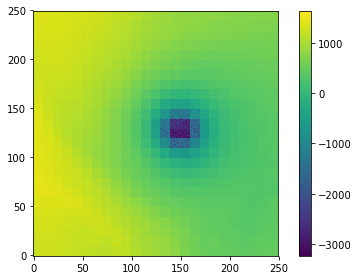

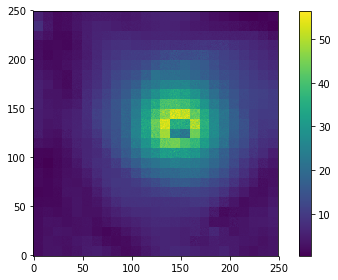

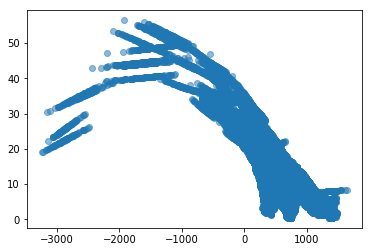

In [154]:
showImage(recon_data0[0])
showImage(recon_data0[1])
#scatter plot of the MV
plt.scatter(recon_data0[0].flatten(), recon_data0[1].flatten(), alpha=0.5)
plt.show()

In [148]:
#reconstruction using mote-carlo sampling
recon_data1 = np.zeros(((numVar, YDIM,XDIM)))

for y in range(0,YDIM/stepSize):
    for x in range(0,XDIM/stepSize):
        correl_matrix = np.zeros((numVar,numVar))
        block_correl = ds_correl[0][y*(XDIM/stepSize) + x]
        correl_matrix[0][0] = 1.0
        correl_matrix[0][1] = block_correl
        correl_matrix[1][0] = 1.0
        correl_matrix[1][1] = block_correl
        
        mean_vector = np.zeros((numVar)) #standard normals have 0 mean
        
        sampledata = np.random.multivariate_normal(mean_vector, correl_matrix, 5*10*10)
        uData = norm.cdf(sampledata)
                
        #for each grid take average of 5 samples
        MVsamples = np.zeros((5*10*10,numVar))
        for k in range(0,5*10*10):
            MVsamples[k][0] = stats.norm.ppf(q=uData[k,0],loc=ds_Gaussian[0][y*(XDIM/stepSize) + x][0],scale=ds_Gaussian[0][y*(XDIM/stepSize) + x][1])
            MVsamples[k][1] = stats.norm.ppf(q=uData[k,1],loc=ds_Gaussian[1][y*(XDIM/stepSize) + x][0],scale=ds_Gaussian[1][y*(XDIM/stepSize) + x][1])
        
        MVsamples1 = np.zeros((10*10,numVar))
        for k in range(0,10*10):
            t_sum0 = 0.0
            t_sum1 = 0.0
            for l in range(0,5):
                t_sum0 += MVsamples[k*5+l][0]
                t_sum1 += MVsamples[k*5+l][1]
            MVsamples1[k][0] = t_sum0/5.0
            MVsamples1[k][1] = t_sum1/5.0
        idx = 0
        for yy in range(0,10):
            for xx in range(0,10):
                recon_data1[0][y*10+yy][x*10+xx] = MVsamples1[idx][0]
                recon_data1[1][y*10+yy][x*10+xx] = MVsamples1[idx][1]
                idx += 1
        print "[" + str(y) + "][" + str(x) + "]"  
                   
        

[0][0]
[0][1]
[0][2]
[0][3]


/home/hazarika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


[0][4]
[0][5]
[0][6]
[0][7]
[0][8]
[0][9]
[0][10]
[0][11]
[0][12]
[0][13]
[0][14]
[0][15]
[0][16]
[0][17]
[0][18]
[0][19]
[0][20]
[0][21]
[0][22]
[0][23]
[0][24]
[1][0]
[1][1]
[1][2]
[1][3]
[1][4]
[1][5]
[1][6]
[1][7]
[1][8]
[1][9]
[1][10]
[1][11]
[1][12]
[1][13]
[1][14]
[1][15]
[1][16]
[1][17]
[1][18]
[1][19]
[1][20]
[1][21]
[1][22]
[1][23]
[1][24]
[2][0]
[2][1]
[2][2]
[2][3]
[2][4]
[2][5]
[2][6]
[2][7]
[2][8]
[2][9]
[2][10]
[2][11]
[2][12]
[2][13]
[2][14]
[2][15]
[2][16]
[2][17]
[2][18]
[2][19]
[2][20]
[2][21]
[2][22]
[2][23]
[2][24]
[3][0]
[3][1]
[3][2]
[3][3]
[3][4]
[3][5]
[3][6]
[3][7]
[3][8]
[3][9]
[3][10]
[3][11]
[3][12]
[3][13]
[3][14]
[3][15]
[3][16]
[3][17]
[3][18]
[3][19]
[3][20]
[3][21]
[3][22]
[3][23]
[3][24]
[4][0]
[4][1]
[4][2]
[4][3]
[4][4]
[4][5]
[4][6]
[4][7]
[4][8]
[4][9]
[4][10]
[4][11]
[4][12]
[4][13]
[4][14]
[4][15]
[4][16]
[4][17]
[4][18]
[4][19]
[4][20]
[4][21]
[4][22]
[4][23]
[4][24]
[5][0]
[5][1]
[5][2]
[5][3]
[5][4]
[5][5]
[5][6]
[5][7]
[5][8]
[5][9]
[5][10]


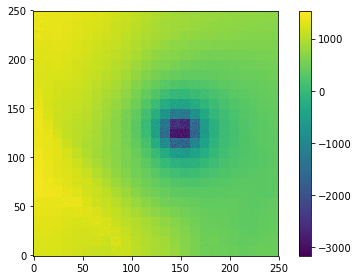

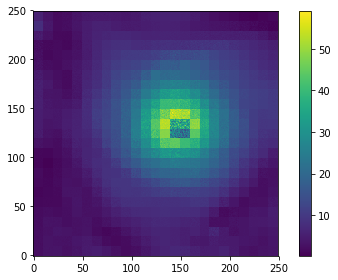

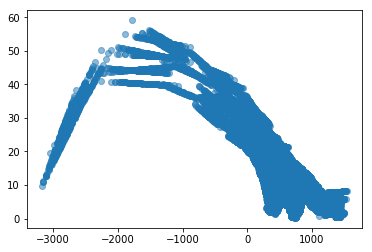

In [149]:
showImage(recon_data1[0])
showImage(recon_data1[1])
#scatter plot of the MV
plt.scatter(recon_data1[0].flatten(), recon_data1[1].flatten(), alpha=0.5)
plt.show()

In [155]:
#reconstruction using mote-carlo sampling
recon_data2 = np.zeros(((numVar, YDIM,XDIM)))

for y in range(0,YDIM/stepSize):
    for x in range(0,XDIM/stepSize):
        s0 = np.random.normal(ds_Gaussian[0][y*(XDIM/stepSize) + x][0], ds_Gaussian[0][y*(XDIM/stepSize) + x][1], 5*10*10)
        s1 = np.random.normal(ds_Gaussian[1][y*(XDIM/stepSize) + x][0], ds_Gaussian[1][y*(XDIM/stepSize) + x][1], 5*10*10)        
        #for each grid take average of 5 samples
        MVsamples = np.zeros((5*10*10,numVar))
        for k in range(0,5*10*10):
            MVsamples[k][0] = s0[k]
            MVsamples[k][1] = s1[k]
        
        MVsamples1 = np.zeros((10*10,numVar))
        for k in range(0,10*10):
            t_sum0 = 0.0
            t_sum1 = 0.0
            for l in range(0,5):
                t_sum0 += MVsamples[k*5+l][0]
                t_sum1 += MVsamples[k*5+l][1]
            MVsamples1[k][0] = t_sum0/5.0
            MVsamples1[k][1] = t_sum1/5.0
        idx = 0
        for yy in range(0,10):
            for xx in range(0,10):
                recon_data2[0][y*10+yy][x*10+xx] = MVsamples1[idx][0]
                recon_data2[1][y*10+yy][x*10+xx] = MVsamples1[idx][1]
                idx += 1
        print "[" + str(y) + "][" + str(x) + "]"  
                   

[0][0]
[0][1]
[0][2]
[0][3]
[0][4]
[0][5]
[0][6]
[0][7]
[0][8]
[0][9]
[0][10]
[0][11]
[0][12]
[0][13]
[0][14]
[0][15]
[0][16]
[0][17]
[0][18]
[0][19]
[0][20]
[0][21]
[0][22]
[0][23]
[0][24]
[1][0]
[1][1]
[1][2]
[1][3]
[1][4]
[1][5]
[1][6]
[1][7]
[1][8]
[1][9]
[1][10]
[1][11]
[1][12]
[1][13]
[1][14]
[1][15]
[1][16]
[1][17]
[1][18]
[1][19]
[1][20]
[1][21]
[1][22]
[1][23]
[1][24]
[2][0]
[2][1]
[2][2]
[2][3]
[2][4]
[2][5]
[2][6]
[2][7]
[2][8]
[2][9]
[2][10]
[2][11]
[2][12]
[2][13]
[2][14]
[2][15]
[2][16]
[2][17]
[2][18]
[2][19]
[2][20]
[2][21]
[2][22]
[2][23]
[2][24]
[3][0]
[3][1]
[3][2]
[3][3]
[3][4]
[3][5]
[3][6]
[3][7]
[3][8]
[3][9]
[3][10]
[3][11]
[3][12]
[3][13]
[3][14]
[3][15]
[3][16]
[3][17]
[3][18]
[3][19]
[3][20]
[3][21]
[3][22]
[3][23]
[3][24]
[4][0]
[4][1]
[4][2]
[4][3]
[4][4]
[4][5]
[4][6]
[4][7]
[4][8]
[4][9]
[4][10]
[4][11]
[4][12]
[4][13]
[4][14]
[4][15]
[4][16]
[4][17]
[4][18]
[4][19]
[4][20]
[4][21]
[4][22]
[4][23]
[4][24]
[5][0]
[5][1]
[5][2]
[5][3]
[5][4]
[5][5]
[5][6]
[

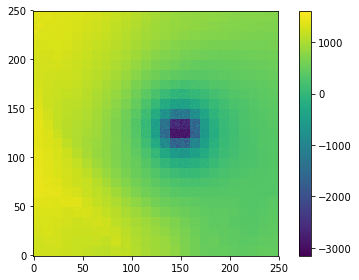

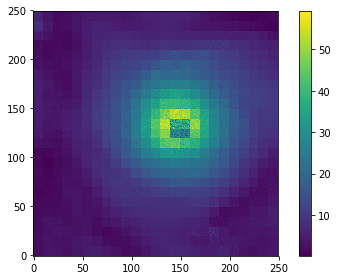

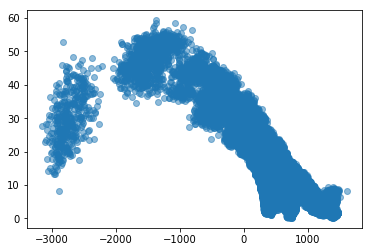

In [156]:
showImage(recon_data2[0])
showImage(recon_data2[1])
#scatter plot of the MV
plt.scatter(recon_data2[0].flatten(), recon_data2[1].flatten(), alpha=0.5)
plt.show()

In [176]:
def inverseCDFofHistogram(support, cdfValue, unifValue):
    maxCDF = max(cdfValue)
    minCDF = min(cdfValue)
    #print maxCDF
    #print minCDF
    if unifValue > maxCDF or unifValue < minCDF:
        if unifValue > maxCDF:
            unifValue = maxCDF
        if unifValue < minCDF:
            unifValue = minCDF
        
    if unifValue > maxCDF or unifValue < minCDF:
        #print unifValue
        raise ValueError('A very specific bad thing happened')
        return -1000
    else:
        l = support.shape
        for i in range(0,l[0]):
            if unifValue >= cdfValue[i] and unifValue <= cdfValue[i+1]:
                left = i;
                right = i+1;
                ratio = (unifValue-cdfValue[i])/(cdfValue[i+1]-cdfValue[i])
                value = ratio * (support[i+1]-support[i]) + support[i]
                return value

In [177]:
#reconstruction using mote-carlo sampling
recon_data3 = np.zeros(((numVar, YDIM,XDIM)))

for y in range(0,YDIM/stepSize):
    for x in range(0,XDIM/stepSize):
        correl_matrix = np.zeros((numVar,numVar))
        block_correl = kmeans.cluster_centers_[correl_cluster[y*(XDIM/stepSize) + x]]
        correl_matrix[0][0] = 1.0
        correl_matrix[0][1] = block_correl
        correl_matrix[1][0] = 1.0
        correl_matrix[1][1] = block_correl
        
        mean_vector = np.zeros((numVar)) #standard normals have 0 mean
        
        sampledata = np.random.multivariate_normal(mean_vector, correl_matrix, 5*10*10)
        uData = norm.cdf(sampledata)
                
        #for each grid take average of 5 samples
        MVsamples = np.zeros((5*10*10,numVar))
        for k in range(0,5*10*10):
            MVsamples[k][0] = inverseCDFofHistogram(ds_Hist_binEdges[0][y*(XDIM/stepSize) + x], ds_Hist_cdf[0][y*(XDIM/stepSize) + x], uData[k,0])
            MVsamples[k][1] = inverseCDFofHistogram(ds_Hist_binEdges[1][y*(XDIM/stepSize) + x], ds_Hist_cdf[1][y*(XDIM/stepSize) + x], uData[k,1])
        
        MVsamples1 = np.zeros((10*10,numVar))
        for k in range(0,10*10):
            t_sum0 = 0.0
            t_sum1 = 0.0
            for l in range(0,5):
                t_sum0 += MVsamples[k*5+l][0]
                t_sum1 += MVsamples[k*5+l][1]
            MVsamples1[k][0] = t_sum0/5.0
            MVsamples1[k][1] = t_sum1/5.0
        idx = 0
        for yy in range(0,10):
            for xx in range(0,10):
                recon_data3[0][y*10+yy][x*10+xx] = MVsamples1[idx][0]
                recon_data3[1][y*10+yy][x*10+xx] = MVsamples1[idx][1]
                idx += 1
        print "[" + str(y) + "][" + str(x) + "]"

[0][0]
[0][1]
[0][2]
[0][3]
[0][4]
[0][5]
[0][6]
[0][7]
[0][8]
[0][9]
[0][10]


/home/hazarika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/home/hazarika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


[0][11]
[0][12]
[0][13]
[0][14]
[0][15]
[0][16]
[0][17]
[0][18]
[0][19]
[0][20]
[0][21]
[0][22]
[0][23]
[0][24]
[1][0]
[1][1]
[1][2]
[1][3]
[1][4]
[1][5]
[1][6]
[1][7]
[1][8]
[1][9]
[1][10]
[1][11]
[1][12]
[1][13]
[1][14]
[1][15]
[1][16]
[1][17]
[1][18]
[1][19]
[1][20]
[1][21]
[1][22]
[1][23]
[1][24]
[2][0]
[2][1]
[2][2]
[2][3]
[2][4]
[2][5]
[2][6]
[2][7]
[2][8]
[2][9]
[2][10]
[2][11]
[2][12]
[2][13]
[2][14]
[2][15]
[2][16]
[2][17]
[2][18]
[2][19]
[2][20]
[2][21]
[2][22]
[2][23]
[2][24]
[3][0]
[3][1]
[3][2]
[3][3]
[3][4]
[3][5]
[3][6]
[3][7]
[3][8]
[3][9]
[3][10]
[3][11]
[3][12]
[3][13]
[3][14]
[3][15]
[3][16]
[3][17]
[3][18]
[3][19]
[3][20]
[3][21]
[3][22]
[3][23]
[3][24]
[4][0]
[4][1]
[4][2]
[4][3]
[4][4]
[4][5]
[4][6]
[4][7]
[4][8]
[4][9]
[4][10]
[4][11]
[4][12]
[4][13]
[4][14]
[4][15]
[4][16]
[4][17]
[4][18]
[4][19]
[4][20]
[4][21]
[4][22]
[4][23]
[4][24]
[5][0]
[5][1]
[5][2]
[5][3]
[5][4]
[5][5]
[5][6]
[5][7]
[5][8]
[5][9]
[5][10]
[5][11]
[5][12]
[5][13]
[5][14]
[5][15]
[5][16]
[5

In [194]:
def handleNAN(d):
    nan_c = 0
    for i in range(0,YDIM):
        for j in range(0,XDIM):
            if math.isnan(d[0][i][j]):
                blockX = int(j/stepSize)
                blockY = int(i/stepSize)
                d[0][i][j] = ds_Gaussian[0][blockY*(XDIM/stepSize) + blockX][0]
            if math.isnan(d[1][i][j]):
                blockX = int(j/stepSize)
                blockY = int(i/stepSize)
                d[1][i][j] = ds_Gaussian[1][blockY*(XDIM/stepSize) + blockX][0]


In [195]:
handleNAN(recon_data3)

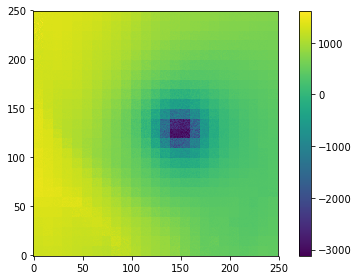

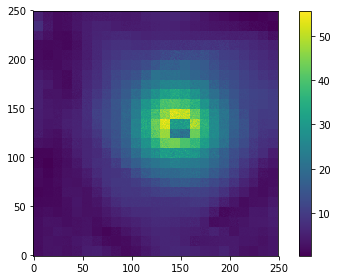

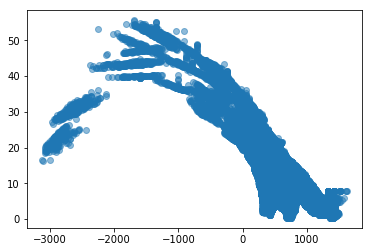

In [196]:
showImage(recon_data3[0])
showImage(recon_data3[1])
#scatter plot of the MV
plt.scatter(recon_data3[0].flatten(), recon_data3[1].flatten(), alpha=0.5)
plt.show()

0


In [179]:
#reconstruction using mote-carlo sampling
recon_data4 = np.zeros(((numVar, YDIM,XDIM)))

for y in range(0,YDIM/stepSize):
    for x in range(0,XDIM/stepSize):
        correl_matrix = np.zeros((numVar,numVar))
        block_correl = ds_correl[0][y*(XDIM/stepSize) + x]
        correl_matrix[0][0] = 1.0
        correl_matrix[0][1] = block_correl
        correl_matrix[1][0] = 1.0
        correl_matrix[1][1] = block_correl
        
        mean_vector = np.zeros((numVar)) #standard normals have 0 mean
        
        sampledata = np.random.multivariate_normal(mean_vector, correl_matrix, 5*10*10)
        uData = norm.cdf(sampledata)
                
        #for each grid take average of 5 samples
        MVsamples = np.zeros((5*10*10,numVar))
        for k in range(0,5*10*10):
            MVsamples[k][0] = inverseCDFofHistogram(ds_Hist_binEdges[0][y*(XDIM/stepSize) + x], ds_Hist_cdf[0][y*(XDIM/stepSize) + x], uData[k,0])
            MVsamples[k][1] = inverseCDFofHistogram(ds_Hist_binEdges[1][y*(XDIM/stepSize) + x], ds_Hist_cdf[1][y*(XDIM/stepSize) + x], uData[k,1])
        
        MVsamples1 = np.zeros((10*10,numVar))
        for k in range(0,10*10):
            t_sum0 = 0.0
            t_sum1 = 0.0
            for l in range(0,5):
                t_sum0 += MVsamples[k*5+l][0]
                t_sum1 += MVsamples[k*5+l][1]
            MVsamples1[k][0] = t_sum0/5.0
            MVsamples1[k][1] = t_sum1/5.0
        idx = 0
        for yy in range(0,10):
            for xx in range(0,10):
                recon_data4[0][y*10+yy][x*10+xx] = MVsamples1[idx][0]
                recon_data4[1][y*10+yy][x*10+xx] = MVsamples1[idx][1]
                idx += 1
        print "[" + str(y) + "][" + str(x) + "]"

[0][0]
[0][1]
[0][2]
[0][3]
[0][4]
[0][5]
[0][6]
[0][7]
[0][8]
[0][9]
[0][10]


/home/hazarika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/home/hazarika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


[0][11]
[0][12]
[0][13]
[0][14]
[0][15]
[0][16]
[0][17]
[0][18]
[0][19]
[0][20]
[0][21]
[0][22]
[0][23]
[0][24]
[1][0]
[1][1]
[1][2]
[1][3]
[1][4]
[1][5]
[1][6]
[1][7]
[1][8]
[1][9]
[1][10]
[1][11]
[1][12]
[1][13]
[1][14]
[1][15]
[1][16]
[1][17]
[1][18]
[1][19]
[1][20]
[1][21]
[1][22]
[1][23]
[1][24]
[2][0]
[2][1]
[2][2]
[2][3]
[2][4]
[2][5]
[2][6]
[2][7]
[2][8]
[2][9]
[2][10]
[2][11]
[2][12]
[2][13]
[2][14]
[2][15]
[2][16]
[2][17]
[2][18]
[2][19]
[2][20]
[2][21]
[2][22]
[2][23]
[2][24]
[3][0]
[3][1]
[3][2]
[3][3]
[3][4]
[3][5]
[3][6]
[3][7]
[3][8]
[3][9]
[3][10]
[3][11]
[3][12]
[3][13]
[3][14]
[3][15]
[3][16]
[3][17]
[3][18]
[3][19]
[3][20]
[3][21]
[3][22]
[3][23]
[3][24]
[4][0]
[4][1]
[4][2]
[4][3]
[4][4]
[4][5]
[4][6]
[4][7]
[4][8]
[4][9]
[4][10]
[4][11]
[4][12]
[4][13]
[4][14]
[4][15]
[4][16]
[4][17]
[4][18]
[4][19]
[4][20]
[4][21]
[4][22]
[4][23]
[4][24]
[5][0]
[5][1]
[5][2]
[5][3]
[5][4]
[5][5]
[5][6]
[5][7]
[5][8]
[5][9]
[5][10]
[5][11]
[5][12]
[5][13]
[5][14]
[5][15]
[5][16]
[5

In [197]:
handleNAN(recon_data4)

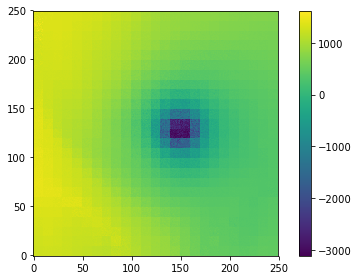

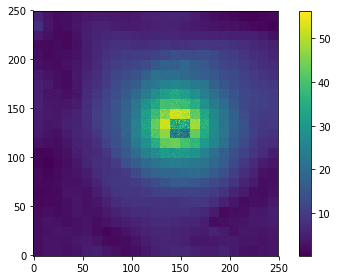

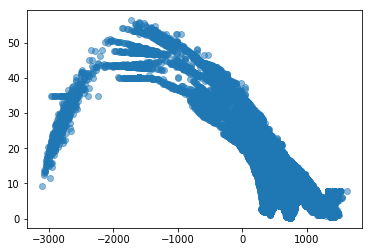

In [198]:
showImage(recon_data4[0])
showImage(recon_data4[1])
#scatter plot of the MV
plt.scatter(recon_data4[0].flatten(), recon_data4[1].flatten(), alpha=0.5)
plt.show()

In [185]:
#reconstruction using mote-carlo sampling
recon_data5 = np.zeros(((numVar, YDIM,XDIM)))

for y in range(0,YDIM/stepSize):
    for x in range(0,XDIM/stepSize):
        
        
        #for each grid take average of 5 samples
        MVsamples = np.zeros((5*10*10,numVar))
        for k in range(0,5*10*10):
            MVsamples[k][0] = inverseCDFofHistogram(ds_Hist_binEdges[0][y*(XDIM/stepSize) + x], ds_Hist_cdf[0][y*(XDIM/stepSize) + x], np.random.random_sample())
            MVsamples[k][1] = inverseCDFofHistogram(ds_Hist_binEdges[1][y*(XDIM/stepSize) + x], ds_Hist_cdf[1][y*(XDIM/stepSize) + x], np.random.random_sample())
        
        MVsamples1 = np.zeros((10*10,numVar))
        for k in range(0,10*10):
            t_sum0 = 0.0
            t_sum1 = 0.0
            for l in range(0,5):
                t_sum0 += MVsamples[k*5+l][0]
                t_sum1 += MVsamples[k*5+l][1]
            MVsamples1[k][0] = t_sum0/5.0
            MVsamples1[k][1] = t_sum1/5.0
        idx = 0
        for yy in range(0,10):
            for xx in range(0,10):
                recon_data5[0][y*10+yy][x*10+xx] = MVsamples1[idx][0]
                recon_data5[1][y*10+yy][x*10+xx] = MVsamples1[idx][1]
                idx += 1
        print "[" + str(y) + "][" + str(x) + "]"

[0][0]
[0][1]
[0][2]
[0][3]
[0][4]
[0][5]
[0][6]
[0][7]
[0][8]
[0][9]


/home/hazarika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


[0][10]
[0][11]
[0][12]
[0][13]
[0][14]
[0][15]
[0][16]
[0][17]
[0][18]
[0][19]
[0][20]
[0][21]
[0][22]
[0][23]
[0][24]
[1][0]
[1][1]
[1][2]
[1][3]
[1][4]
[1][5]
[1][6]
[1][7]
[1][8]
[1][9]
[1][10]
[1][11]
[1][12]
[1][13]
[1][14]
[1][15]
[1][16]
[1][17]
[1][18]
[1][19]
[1][20]
[1][21]
[1][22]
[1][23]
[1][24]
[2][0]
[2][1]
[2][2]
[2][3]
[2][4]
[2][5]
[2][6]
[2][7]
[2][8]
[2][9]
[2][10]
[2][11]
[2][12]
[2][13]
[2][14]
[2][15]
[2][16]
[2][17]
[2][18]
[2][19]
[2][20]
[2][21]
[2][22]
[2][23]
[2][24]
[3][0]
[3][1]
[3][2]
[3][3]
[3][4]
[3][5]
[3][6]
[3][7]
[3][8]
[3][9]
[3][10]
[3][11]
[3][12]
[3][13]
[3][14]
[3][15]
[3][16]
[3][17]
[3][18]
[3][19]
[3][20]
[3][21]
[3][22]
[3][23]
[3][24]
[4][0]
[4][1]
[4][2]
[4][3]
[4][4]
[4][5]
[4][6]
[4][7]
[4][8]
[4][9]
[4][10]
[4][11]
[4][12]
[4][13]
[4][14]
[4][15]
[4][16]
[4][17]
[4][18]
[4][19]
[4][20]
[4][21]
[4][22]
[4][23]
[4][24]
[5][0]
[5][1]
[5][2]
[5][3]
[5][4]
[5][5]
[5][6]
[5][7]
[5][8]
[5][9]
[5][10]
[5][11]
[5][12]
[5][13]
[5][14]
[5][15]
[5

In [199]:
handleNAN(recon_data5)

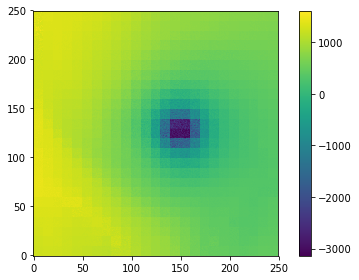

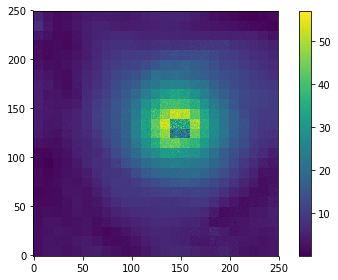

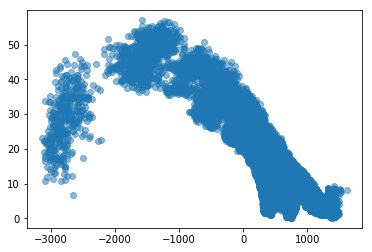

In [200]:
showImage(recon_data5[0])
showImage(recon_data5[1])
#scatter plot of the MV
plt.scatter(recon_data5[0].flatten(), recon_data5[1].flatten(), alpha=0.5)
plt.show()

In [201]:
#reconstruction using mote-carlo sampling
recon_data6 = np.zeros(((numVar, YDIM,XDIM)))

for y in range(0,YDIM/stepSize):
    for x in range(0,XDIM/stepSize):
        correl_matrix = np.zeros((numVar,numVar))
        block_correl = kmeans.cluster_centers_[correl_cluster[y*(XDIM/stepSize) + x]]
        correl_matrix[0][0] = 1.0
        correl_matrix[0][1] = block_correl
        correl_matrix[1][0] = 1.0
        correl_matrix[1][1] = block_correl
        
        mean_vector = np.zeros((numVar)) #standard normals have 0 mean
        
        sampledata = np.random.multivariate_normal(mean_vector, correl_matrix, 5*10*10)
        uData = norm.cdf(sampledata)
                
        #for each grid take average of 5 samples
        MVsamples = np.zeros((5*10*10,numVar))
        for k in range(0,5*10*10):
            if pvalue[0][y*(XDIM/stepSize) + x] > 0.6:
                MVsamples[k][0] = stats.norm.ppf(q=uData[k,0],loc=ds_Gaussian[0][y*(XDIM/stepSize) + x][0],scale=ds_Gaussian[0][y*(XDIM/stepSize) + x][1])
            else:
                MVsamples[k][0] = inverseCDFofHistogram(ds_Hist_binEdges[0][y*(XDIM/stepSize) + x], ds_Hist_cdf[0][y*(XDIM/stepSize) + x], uData[k,0])
            
            if pvalue[1][y*(XDIM/stepSize) + x] > 0.6:
                MVsamples[k][1] = stats.norm.ppf(q=uData[k,1],loc=ds_Gaussian[1][y*(XDIM/stepSize) + x][0],scale=ds_Gaussian[1][y*(XDIM/stepSize) + x][1])
            else:
                MVsamples[k][1] = inverseCDFofHistogram(ds_Hist_binEdges[1][y*(XDIM/stepSize) + x], ds_Hist_cdf[1][y*(XDIM/stepSize) + x], uData[k,1])

        
        MVsamples1 = np.zeros((10*10,numVar))
        for k in range(0,10*10):
            t_sum0 = 0.0
            t_sum1 = 0.0
            for l in range(0,5):
                t_sum0 += MVsamples[k*5+l][0]
                t_sum1 += MVsamples[k*5+l][1]
            MVsamples1[k][0] = t_sum0/5.0
            MVsamples1[k][1] = t_sum1/5.0
        idx = 0
        for yy in range(0,10):
            for xx in range(0,10):
                recon_data6[0][y*10+yy][x*10+xx] = MVsamples1[idx][0]
                recon_data6[1][y*10+yy][x*10+xx] = MVsamples1[idx][1]
                idx += 1
        print "[" + str(y) + "][" + str(x) + "]"

[0][0]
[0][1]
[0][2]
[0][3]
[0][4]
[0][5]
[0][6]


/home/hazarika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app
/home/hazarika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


[0][7]
[0][8]
[0][9]
[0][10]
[0][11]
[0][12]
[0][13]
[0][14]
[0][15]
[0][16]
[0][17]
[0][18]
[0][19]
[0][20]
[0][21]
[0][22]
[0][23]
[0][24]
[1][0]
[1][1]
[1][2]
[1][3]
[1][4]
[1][5]
[1][6]
[1][7]
[1][8]
[1][9]
[1][10]
[1][11]
[1][12]
[1][13]
[1][14]
[1][15]
[1][16]
[1][17]
[1][18]
[1][19]
[1][20]
[1][21]
[1][22]
[1][23]
[1][24]
[2][0]
[2][1]
[2][2]
[2][3]
[2][4]
[2][5]
[2][6]
[2][7]
[2][8]
[2][9]
[2][10]
[2][11]
[2][12]
[2][13]
[2][14]
[2][15]
[2][16]
[2][17]
[2][18]
[2][19]
[2][20]
[2][21]
[2][22]
[2][23]
[2][24]
[3][0]
[3][1]
[3][2]
[3][3]
[3][4]
[3][5]
[3][6]
[3][7]
[3][8]
[3][9]
[3][10]
[3][11]
[3][12]
[3][13]
[3][14]
[3][15]
[3][16]
[3][17]
[3][18]
[3][19]
[3][20]
[3][21]
[3][22]
[3][23]
[3][24]
[4][0]
[4][1]
[4][2]
[4][3]
[4][4]
[4][5]
[4][6]
[4][7]
[4][8]
[4][9]
[4][10]
[4][11]
[4][12]
[4][13]
[4][14]
[4][15]
[4][16]
[4][17]
[4][18]
[4][19]
[4][20]
[4][21]
[4][22]
[4][23]
[4][24]
[5][0]
[5][1]
[5][2]
[5][3]
[5][4]
[5][5]
[5][6]
[5][7]
[5][8]
[5][9]
[5][10]
[5][11]
[5][12]
[5][1

In [203]:
handleNAN(recon_data6)

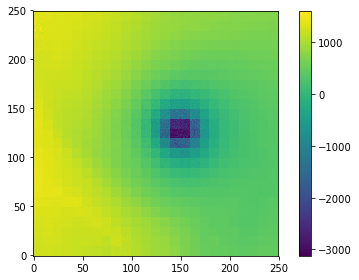

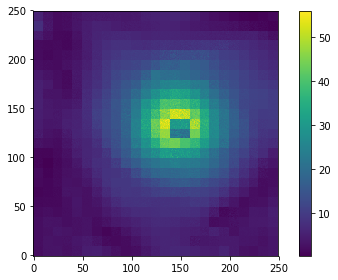

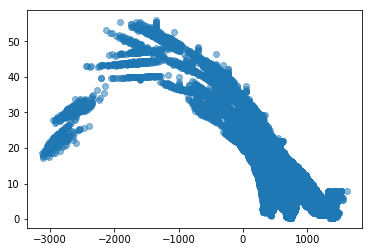

In [204]:
showImage(recon_data6[0])
showImage(recon_data6[1])
#scatter plot of the MV
plt.scatter(recon_data6[0].flatten(), recon_data6[1].flatten(), alpha=0.5)
plt.show()

In [205]:
#reconstruction using mote-carlo sampling
recon_data7 = np.zeros(((numVar, YDIM,XDIM)))

for y in range(0,YDIM/stepSize):
    for x in range(0,XDIM/stepSize):
        correl_matrix = np.zeros((numVar,numVar))
        block_correl = ds_correl[0][y*(XDIM/stepSize) + x]
        correl_matrix[0][0] = 1.0
        correl_matrix[0][1] = block_correl
        correl_matrix[1][0] = 1.0
        correl_matrix[1][1] = block_correl
        
        mean_vector = np.zeros((numVar)) #standard normals have 0 mean
        
        sampledata = np.random.multivariate_normal(mean_vector, correl_matrix, 5*10*10)
        uData = norm.cdf(sampledata)
                
        #for each grid take average of 5 samples
        MVsamples = np.zeros((5*10*10,numVar))
        for k in range(0,5*10*10):
            if pvalue[0][y*(XDIM/stepSize) + x] > 0.6:
                MVsamples[k][0] = stats.norm.ppf(q=uData[k,0],loc=ds_Gaussian[0][y*(XDIM/stepSize) + x][0],scale=ds_Gaussian[0][y*(XDIM/stepSize) + x][1])
            else:
                MVsamples[k][0] = inverseCDFofHistogram(ds_Hist_binEdges[0][y*(XDIM/stepSize) + x], ds_Hist_cdf[0][y*(XDIM/stepSize) + x], uData[k,0])
            
            if pvalue[1][y*(XDIM/stepSize) + x] > 0.6:
                MVsamples[k][1] = stats.norm.ppf(q=uData[k,1],loc=ds_Gaussian[1][y*(XDIM/stepSize) + x][0],scale=ds_Gaussian[1][y*(XDIM/stepSize) + x][1])
            else:
                MVsamples[k][1] = inverseCDFofHistogram(ds_Hist_binEdges[1][y*(XDIM/stepSize) + x], ds_Hist_cdf[1][y*(XDIM/stepSize) + x], uData[k,1])

        
        MVsamples1 = np.zeros((10*10,numVar))
        for k in range(0,10*10):
            t_sum0 = 0.0
            t_sum1 = 0.0
            for l in range(0,5):
                t_sum0 += MVsamples[k*5+l][0]
                t_sum1 += MVsamples[k*5+l][1]
            MVsamples1[k][0] = t_sum0/5.0
            MVsamples1[k][1] = t_sum1/5.0
        idx = 0
        for yy in range(0,10):
            for xx in range(0,10):
                recon_data7[0][y*10+yy][x*10+xx] = MVsamples1[idx][0]
                recon_data7[1][y*10+yy][x*10+xx] = MVsamples1[idx][1]
                idx += 1
        print "[" + str(y) + "][" + str(x) + "]"

[0][0]
[0][1]
[0][2]
[0][3]
[0][4]
[0][5]
[0][6]


/home/hazarika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app
/home/hazarika/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


[0][7]
[0][8]
[0][9]
[0][10]
[0][11]
[0][12]
[0][13]
[0][14]
[0][15]
[0][16]
[0][17]
[0][18]
[0][19]
[0][20]
[0][21]
[0][22]
[0][23]
[0][24]
[1][0]
[1][1]
[1][2]
[1][3]
[1][4]
[1][5]
[1][6]
[1][7]
[1][8]
[1][9]
[1][10]
[1][11]
[1][12]
[1][13]
[1][14]
[1][15]
[1][16]
[1][17]
[1][18]
[1][19]
[1][20]
[1][21]
[1][22]
[1][23]
[1][24]
[2][0]
[2][1]
[2][2]
[2][3]
[2][4]
[2][5]
[2][6]
[2][7]
[2][8]
[2][9]
[2][10]
[2][11]
[2][12]
[2][13]
[2][14]
[2][15]
[2][16]
[2][17]
[2][18]
[2][19]
[2][20]
[2][21]
[2][22]
[2][23]
[2][24]
[3][0]
[3][1]
[3][2]
[3][3]
[3][4]
[3][5]
[3][6]
[3][7]
[3][8]
[3][9]
[3][10]
[3][11]
[3][12]
[3][13]
[3][14]
[3][15]
[3][16]
[3][17]
[3][18]
[3][19]
[3][20]
[3][21]
[3][22]
[3][23]
[3][24]
[4][0]
[4][1]
[4][2]
[4][3]
[4][4]
[4][5]
[4][6]
[4][7]
[4][8]
[4][9]
[4][10]
[4][11]
[4][12]
[4][13]
[4][14]
[4][15]
[4][16]
[4][17]
[4][18]
[4][19]
[4][20]
[4][21]
[4][22]
[4][23]
[4][24]
[5][0]
[5][1]
[5][2]
[5][3]
[5][4]
[5][5]
[5][6]
[5][7]
[5][8]
[5][9]
[5][10]
[5][11]
[5][12]
[5][1

In [206]:
handleNAN(recon_data7)

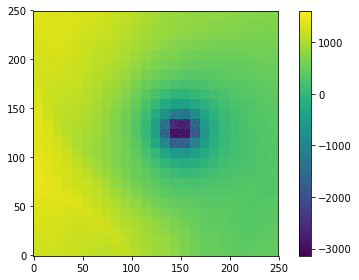

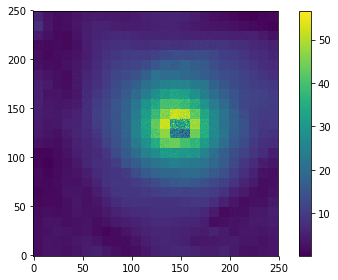

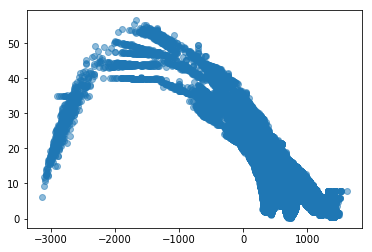

In [208]:
showImage(recon_data7[0])
showImage(recon_data7[1])
#scatter plot of the MV
plt.scatter(recon_data7[0].flatten(), recon_data7[1].flatten(), alpha=0.5)
plt.show()